In [6]:
!pip install yfinance

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_acoes = round(yf.download("FESA4.SA",start="2020-01-01", end="2020-12-30"),2)

[*********************100%%**********************]  1 of 1 completed


In [9]:
df_acoes.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,5.05,5.05,4.87,4.95,4.05,2167200
2020-01-03,4.90,4.99,4.89,4.98,4.07,806400
2020-01-06,4.97,4.97,4.89,4.91,4.01,1339200
2020-01-07,4.93,4.95,4.82,4.92,4.03,1495600
2020-01-08,4.93,4.99,4.87,4.97,4.07,1562800


In [ ]:
acoes = ["FESA4.SA","BOVA11.SA","GRND3.SA"]
carteira = pd.DataFrame()
for acao in acoes:
  carteira[acao] = round(yf.download(acao, start='2020-01-01',end="2020-12-31")['Open'],2)

carteira.to_csv("carteira.csv")
carteira =pd.read_csv("carteira.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


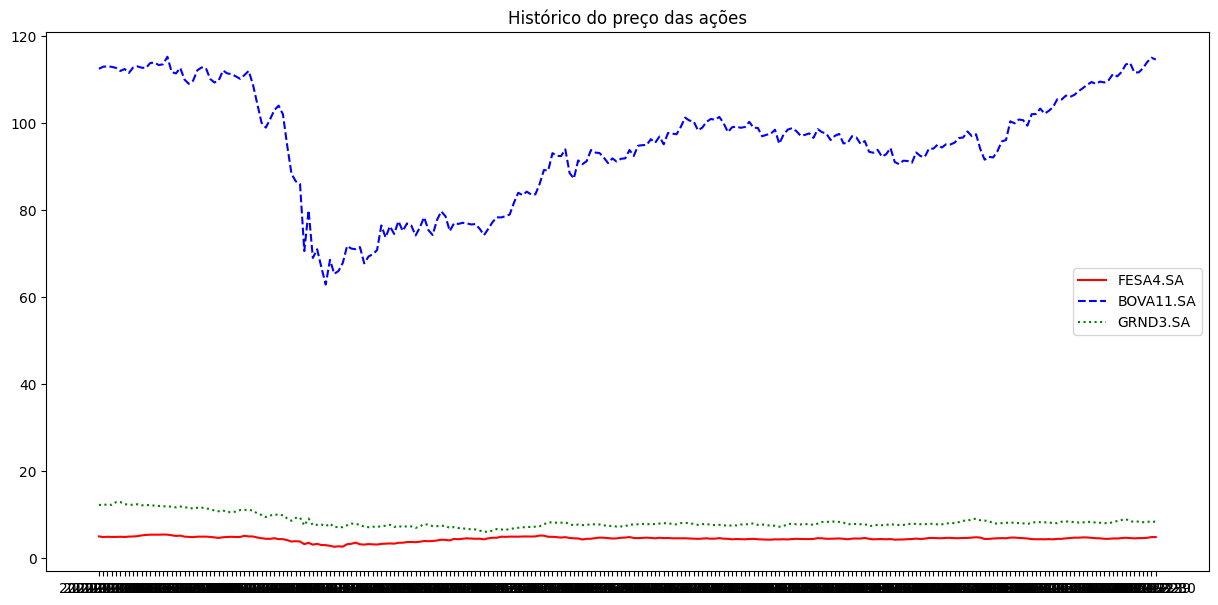

In [11]:
def grafico(carteira):
  linestyles = ['-', '--', ':']
  colors = ['red', 'blue', 'green']

  plt.figure(figsize=(15, 7))
  for i, col in enumerate(carteira.columns[1:]):
      if col != 'Date':
          plt.plot(carteira['Date'], carteira[col], linestyle=linestyles[i], color=colors[i], label=col)


  plt.title('Histórico do preço das ações')
  plt.legend()


plt.show()

grafico(carteira)

## Padronização pela normalização utilizando a biblioteca scikit-learn

In [12]:
from sklearn.preprocessing import StandardScaler

padronizacao = StandardScaler()

In [13]:
padronizacao.fit(carteira[carteira.columns[1:]])

StandardScaler()

In [15]:
carteira.columns[1:]

Index(['FESA4.SA', 'BOVA11.SA', 'GRND3.SA'], dtype='object')

In [16]:
print(f"""Médias calculadas pelo StandardScaler: {padronizacao.mean_}
Desvios padrões calculados pelo StandardScaler: {padronizacao.scale_}  """)

Médias calculadas pelo StandardScaler: [ 4.50935484 95.05076613  8.47229839]
Desvios padrões calculados pelo StandardScaler: [ 0.51736965 12.97255816  1.52653966]  


In [17]:
carteira_norm = pd.DataFrame()
carteira_norm = padronizacao.transform(carteira[carteira.columns[1:]])
carteira_norm = pd.DataFrame(carteira_norm, columns=carteira.columns[1:])
carteira_norm.insert(0, "Date", carteira["Date"])

## Criando um modelo de previsão ARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
modelo = ARIMA(carteira["BOVA11.SA"], order=(2, 0, 1))

In [20]:
resultados = modelo.fit()
previsoes=resultados.predict(start=-len(carteira))

In [21]:
previsao = resultados.forecast(steps=30)

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
mean_absolute_error(carteira["BOVA11.SA"],previsoes)

1.427689978516978

## Padronização com a mediana e quantis (escala robusta)

In [24]:
from sklearn.preprocessing import RobustScaler

In [25]:
robusta = RobustScaler()
robusta.fit(carteira[carteira.columns[1:]])

RobustScaler()

In [26]:
print(f"""Centro calculado:{robusta.center_}
Escala calculada:{robusta.scale_}""")

Centro calculado:[ 4.6  96.63  7.93]
Escala calculada:[ 0.37  14.925  0.85 ]


In [27]:
carteira_robusta = pd.DataFrame()
carteira_robusta = robusta.transform(carteira[carteira.columns[1:]])
carteira_robusta = pd.DataFrame(carteira_robusta, columns=carteira.columns[1:])
carteira_robusta.insert(0, "Date", carteira["Date"])

## Calculando o erro

In [30]:
modelo_robusto = ARIMA(carteira_robusta["BOVA11.SA"],order=(2,0,1))
results = modelo_robusto.fit()

In [32]:
previsoes_r =results.predict(start=-len(carteira_robusta))
previsao_r = results.forecast(steps=30)

In [34]:
mean_absolute_error(carteira_robusta["BOVA11.SA"],previsoes_r)

0.09565693819441047

## Padronização com a média

In [35]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [36]:
standardscaler = StandardScaler(with_mean=True, with_std=False)

In [37]:
robustscaler = RobustScaler(with_centering=False,with_scaling=True, quantile_range=(0,100))

In [38]:
standardscaler.fit(carteira[carteira.columns[1:]])
robustscaler.fit(carteira[carteira.columns[1:]])

RobustScaler(quantile_range=(0, 100), with_centering=False)

In [39]:
dataframe_media = standardscaler.transform(robustscaler.transform(carteira[['FESA4.SA', 'BOVA11.SA', 'GRND3.SA']]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [40]:
carteira_media = pd.DataFrame()
carteira_media = robusta.transform(carteira[carteira.columns[1:]])
carteira_media = pd.DataFrame(dataframe_media, columns=carteira.columns[1:])
carteira_media.insert(0, "Date", carteira["Date"])

In [41]:
carteira_media.head()

,Date,FESA4.SA,BOVA11.SA,GRND3.SA
0,2020-01-02,-2.712202,-92.901082,-6.676678
1,2020-01-03,-2.765583,-92.891905,-6.685437
2,2020-01-06,-2.740672,-92.890567,-6.657700
3,2020-01-07,-2.754906,-92.892479,-6.679598
4,2020-01-08,-2.754906,-92.897258,-6.586167


## Calculando o erro

In [43]:
modelo_media = ARIMA(carteira_media["BOVA11.SA"],order=(2,0,1))
resultado_media = modelo_media.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
previsoes_m =resultado_media.predict(start=-len(carteira_media))
previsao_m = resultado_media.forecast(steps=30)

In [45]:
mean_absolute_error(carteira_media["BOVA11.SA"],previsoes_m)

0.027349397672241614